# Wild Fire Model Evaluation

This notebooks will evaluate severals model on the wildfire dataset in order to make a predecction on fire intensity and CO2 emissions. A down selection will be made to 2-3 models for further hyper-paramater tuning. 

#optional code if warnings become over bearing 
import warnings
warnings.filterwarnings('ignore')

In [1]:
#optional code to ensure everyone is on the right version
import sklearn

print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.23.1.


# Import all the models we will likely use for classificaiton

In [2]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import pickle
import seaborn as sns

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split as tts
from sklearn.utils import resample

#from imblearn import under_sampling, over_sampling
#from imblearn.over_sampling import SMOTE

from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC


/Users/sandstone/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Helper function to save estimator
Saves to current working directory

In [3]:
def save_estimator (estimator) :
          
    outpath = estimator.__class__.__name__.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)
        f.close()
        
    #print("\nFitted model written to:\n{}".format(os.path.abspath(outpath)))

In [4]:
def open_estimator(filename) :
    
    infile = open(filename,'rb')
    estimator = pickle.load(infile)
    infile.close()

    print ("Unpickled file", filename)
    
    return estimator

# Read the Fire Data From Disk to Save Time.
During the feature evaluation the data was pulled from the database and stored locally

In [5]:
#Read the data from disk for faster access

df_fires = pd.read_csv('../data/FireIntensity_Model_June12_Clean.csv')

FileNotFoundError: [Errno 2] File b'../data/FireIntensity_Model_June12_Clean.csv' does not exist: b'../data/FireIntensity_Model_June12_Clean.csv'

In [ ]:
# Random Sample of DF to reduce size:

df_fires = df_fires.sample(frac=0.06, replace=True, random_state=1)
print(df_fires.shape)

In [6]:
#Read the data from disk for faster access
df_fires  = pd.read_csv('data/FireIntensity_Model_June12_Clean.csv').sample(100000)
print(df_fires.shape)
                           

(100000, 26)


# Assess shape and data in the file. 
Check data to ensure it's correct.


In [7]:
# Expanding number of columns:
pd.set_option('display.max_columns', 40)

In [8]:
# review datagram
print (df_fires.shape)
df_fires.head(3)

(100000, 26)


,Unnamed: 0,latitude,longitude,doy,month,year,cluster_reference,fire_region,season,covertype,fuelcode,prefire_fuel,fuel_moisture_class,temperature,humidity,precip_intensity,visibility,wind_speed,wind_gust,brightness,fire_intensity,fire_intensity_twocat,fire_intensity_threecat,fire_intensity_fourcat,bright_t31,frp
1015640,1015640,44.6393,-114.9009,260,9,2012,2012_554,1,1,3,1200,6424.431099,1,55.57,0.35,0.0,9.216293,2.44,6.71,324.9,High,Moderate,Low,Low,293.7,20.3
930057,930057,33.3183,-86.2859,68,3,2012,2012_4045,2,3,3,1160,7020.760516,2,76.07,0.51,0.0,9.997000,5.75,13.76,310.0,Medium,Moderate,Low,Low,278.3,16.5
636387,636387,34.9465,-87.4229,37,2,2009,2009_6082,0,3,3,1500,4335.068543,2,55.62,0.57,0.0,9.997000,4.25,13.82,301.9,Low,Moderate,Low,Low,290.6,4.3


In [9]:
df_fires = df_fires.drop(columns={'latitude', 'longitude','cluster_reference', 'doy', 'month', 'year', 'brightness', 'bright_t31','frp'})

In [10]:
df_fires.head(2)

,Unnamed: 0,fire_region,season,covertype,fuelcode,prefire_fuel,fuel_moisture_class,temperature,humidity,precip_intensity,visibility,wind_speed,wind_gust,fire_intensity,fire_intensity_twocat,fire_intensity_threecat,fire_intensity_fourcat
1015640,1015640,1,1,3,1200,6424.431099,1,55.57,0.35,0.0,9.216293,2.44,6.71,High,Moderate,Low,Low
930057,930057,2,3,3,1160,7020.760516,2,76.07,0.51,0.0,9.997000,5.75,13.76,Medium,Moderate,Low,Low


In [11]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [12]:
#show the shape of the data

print (df_fires.shape)
print (df_fires.describe())
print ("")
print ("")
#print(df_fires['fire_intensity_twocat'].value_counts())

print(df_fires['fire_intensity_fourcat'].value_counts())

(100000, 17)
         Unnamed: 0  fire_region       season    covertype     fuelcode  \
count  100000.00000 100000.00000 100000.00000 100000.00000 100000.00000   
mean   663492.08657      2.73768      1.33400      2.34676    831.30368   
std    383240.00108      2.11855      1.04817      0.88004    709.72510   
min         0.00000      0.00000      0.00000      1.00000      1.00000   
25%    331303.75000      1.00000      0.00000      1.00000      1.00000   
50%    661804.00000      2.00000      1.00000      3.00000   1160.00000   
75%    995836.25000      4.00000      2.00000      3.00000   1280.00000   
max   1328916.00000      7.00000      3.00000      3.00000   2950.00000   

       prefire_fuel  fuel_moisture_class  temperature     humidity  \
count  100000.00000         100000.00000 100000.00000 100000.00000   
mean     3857.06659              2.25952     69.92748      0.41149   
std      3011.88700              0.70607     14.99040      0.16832   
min        19.72714            

# Setting Up Features:

In [13]:
features = ['fire_region', 'season', 'covertype', 'fuelcode', 'fuel_moisture_class', 'prefire_fuel', 'temperature', 'humidity', 'precip_intensity', 'visibility', 'wind_gust', 'wind_speed']

cat_features = ['fire_region', 'season', 'covertype', 'fuelcode', 'fuel_moisture_class']

num_features = ['prefire_fuel', 'temperature', 'humidity', 'precip_intensity', 'visibility', 'wind_gust', 'wind_speed']

target = ['fire_intensity_fourcat']

y = df_fires[target]
y = np.ravel(y)
X = df_fires[features]

#encode_columns = ('fire_region', 'season', 'covertype', 'fuel_moisture_class')
#onehot_list = df_fires[encode_columns]

--- 
Review features:
#skip when in a rush takes a while

In [ ]:
sns.pairplot(X)

## Pipeline to Transform:

In [14]:
# Processing y.
y = LabelEncoder().fit_transform(y) # Label-encode targets before modeling

In [15]:
# Processing X Features. 
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),

#numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler(feature_range=(0, 1), copy=True))])
numeric_transformer = Pipeline(steps=[('scaler', RobustScaler(quantile_range=(25, 75)))])
#numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    #('imputer', SimpleImputer(strategy='median')),


In [16]:
# Setting the transformation for the pipeline below. 
preprocessor = ColumnTransformer (transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])

model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])


#column_trans = make_column_transformer((OneHotEncoder(), ['fire_region', 'season',
 #                               'fuelcode', 'fuel_moisture_class']),
  #                               remainder='passthrough')
    
column_trans.fit_transform(X)
y = LabelEncoder().fit_transform(y)


# Define the models to test
<b>Commented out slower performing models and limited the interations/estimators for speed</b>

In [17]:
'''
    models = [
        SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(), 
        SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(), 
        LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3), 
        BaggingClassifier(), ExtraTreesClassifier(n_estimators=100), 
        RandomForestClassifier(n_estimators=100),
        ]    
'''
models = [RandomForestClassifier(n_estimators=10) ]
#models = [AdaBoostClassifier()]

# Function to Fit and predict the scores of the model. 
Helps in the initial down selection

In [18]:
def score_model(X, y, estimator, **kwargs):
    
    """
    Test various estimators.
    #y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder(categories = 'auto')), 
         ('estimator', estimator)
    ])
    """ 
   
    model = Pipeline(steps=[
          ('preprocessor', preprocessor),
          ('estimator', estimator)
      ])
    
    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected = y
    predicted = model.predict(X)
    
   
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted, average='macro')))
   
    #return save_estimator(estimator)


In [19]:
#Smote the data
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

print(X.tail())

        fire_region  season  covertype  fuelcode  fuel_moisture_class  \
363587            1       2          3      1280                    3   
363588            1       1          3      1200                    2   
363589            1       1          2         2                    2   
363590            4       1          3      1220                    2   
363591            5       1          3      1220                    1   

        prefire_fuel  temperature  humidity  precip_intensity  visibility  \
363587    6594.53440     58.67936   0.44515           0.00000     9.21629   
363588    6424.43110     71.25106   0.29159           0.00000     5.08180   
363589     649.09986     82.34346   0.25669           0.00020     9.99700   
363590    4534.18726     77.81463   0.17134           0.00000     9.64471   
363591    4534.18726     80.58727   0.27476           0.00000     5.06845   

        wind_gust  wind_speed  
363587    7.81827     2.88095  
363588    4.74729     1.75539  
36

# Iterate through the different models

In [20]:
for model in models:
    score_model(X, y, model)

RandomForestClassifier: 0.9638899708331685


# Function to visualize the model out using yellow brick classification report.
<b> Error is thrown here using the LabelEncoder and one_hot_encoder <b/>

In [21]:
def visualize_model(X, y, estimator):
    
    """
    Test various estimators.
    
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder(categories='auto')), 
         ('estimator', estimator)
    ])
    """ 
    
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('estimator', estimator)
    ])
   
   
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model,
        #classes=['Moderate','Severe'],  # Classes for 2 Category Fire Intensity
        #classes=['Low', 'Moderate_to_High', 'Severe'],  # Classes for 3 Category Fire Intensity
        classes=['Low', 'Medium', 'High', 'Severe'], # Classes for equal balanced bins per quartiles
        cmap="Reds", 
        support=True,
        size=(800, 660)
    )
    
    #X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20)
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33) #random_state=42)

    """"
    #combine them back for resampling
    train_data = pd.concat([X_train, y_train], axis=1)# separate minority and majority classes
    negative = train_data[train_data.diagnosis=='Moderate']
    positive = train_data[train_data.diagnosis=='Severe']
    
    # upsample minority
    pos_upsampled = resample(positive,
    replace=True, # sample with replacement
    n_samples=len(negative), # match number in majority class
    random_state=27) # reproducible results# combine majority and upsampled minority
    
    upsampled = pd.concat([negative, pos_upsampled])# check new class counts
    upsampled.diagnosis.value_counts()
    """
                                           
    visualizer.fit(X_train, y_train)  
        
    visualizer.score(X_test, y_test)
    
    #optional
    #visualizer.show(outpath=estimator.__class__.__name__ + ".png")  
    
    visualizer.show()


# Iterate through the models to visualize

/Users/sandstone/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


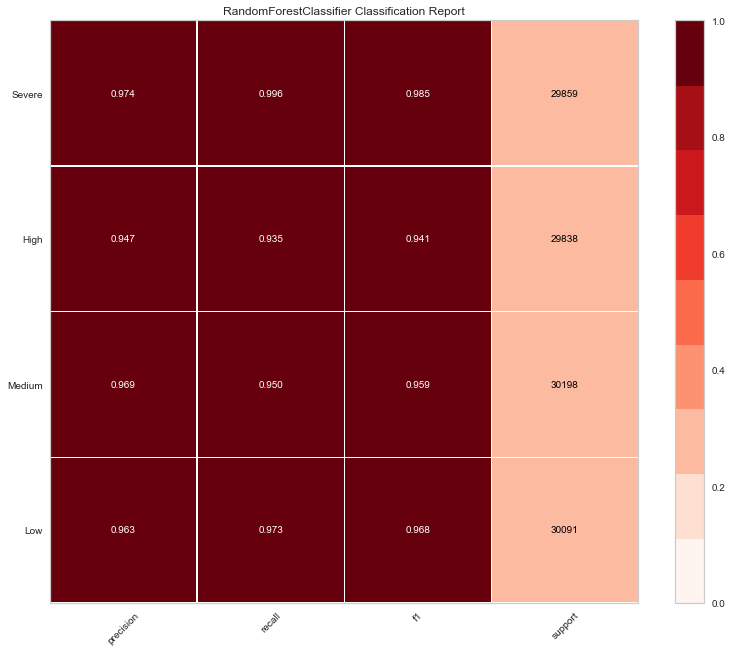

In [22]:
for model in models:
    visualize_model(X, y, model)
    

---
#### ROCAUC

/Users/sandstone/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


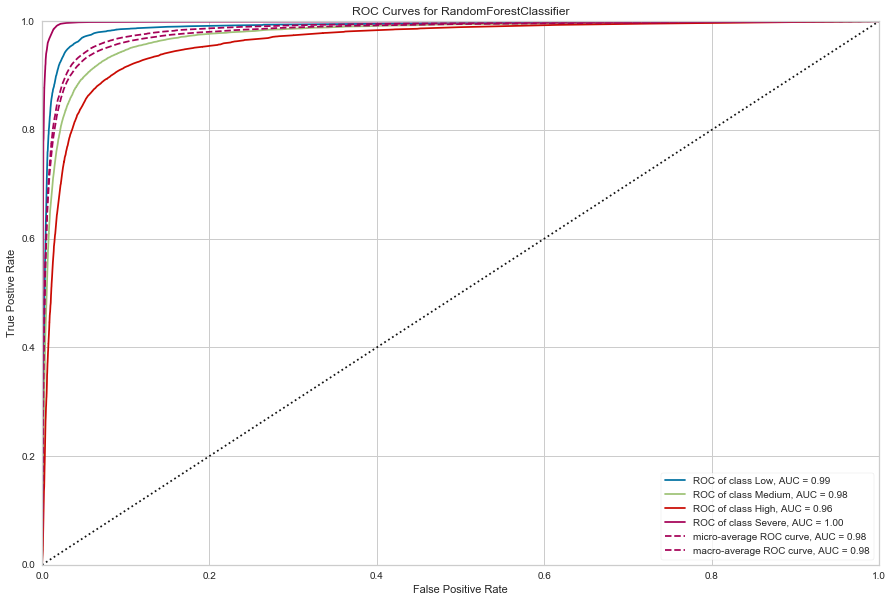

In [23]:

#classes = ['win', 'loss', 'draw']

# Encode the non-numeric columns
#X = OrdinalEncoder().fit_transform(X)
#y = LabelEncoder().fit_transform(y)

#classes=['Moderate','Severe']  # Classes for 2 Category Fire Intensity
#classes=['Low', 'Moderate_to_High', 'Severe']  # Classes for 3 Category Fire Intensity
classes=['Low', 'Medium', 'High', 'Severe']

# Create the train and test data
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.5)

visualizer = ROCAUC(RandomForestClassifier(n_estimators=100), classes=classes, size=(1080, 720))
#visualizer = ROCAUC(RandomForestClassifier(n_estimators=100), size=(1080, 720))
#visualizer = ROCAUC(BaggingClassifier(), size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data

---
#### Class Balance

In [ ]:
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
#visualizer = ClassBalance(size=(1080, 720))
visualizer = ClassBalance(labels=['Low', 'Moderate_to_High', 'Severe'], size=(1080, 720))

visualizer.fit(y)
visualizer.show()

---
#### Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold

from yellowbrick.model_selection import CVScores

# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=12, random_state=42)

# Instantiate the classification model and visualizer
#model = RandomForestClassifier(n_estimators=100)
model = RandomForestClassifier(n_estimators=100)
visualizer = CVScores(
    model, cv=cv, scoring='f1_weighted', size=(1080, 720)
)

visualizer.fit(X, y)
visualizer.show()